## Calculate water transports and save in files


This notebook calculates the water transport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is calculated as $u_i * a_i$, with units m3/s and each transport xarray dataset is stored in a file according to its orientation:

* run##water_CS_transports.nc - cross-shelf and vertical transports

There is one of each files for every run.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr

In [14]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 60)
CS2_x_slice = slice(60, 120)
CS3_x_slice = slice(120, 240)
CS4_x_slice = slice(240, 300)
CS5_x_slice = slice(300, 360)
CS6_x_slice = slice(360, 616)
CSCOAST_x_slice = slice(0, 616)

CS_y_coast = 358
CS_y_ind = 131
HD_y_ind = 160
SB_ind = 40
BBL_ind = 38
UP_x_ind = 120
DN_x_ind = 240

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0,0.5,'depth [m]')

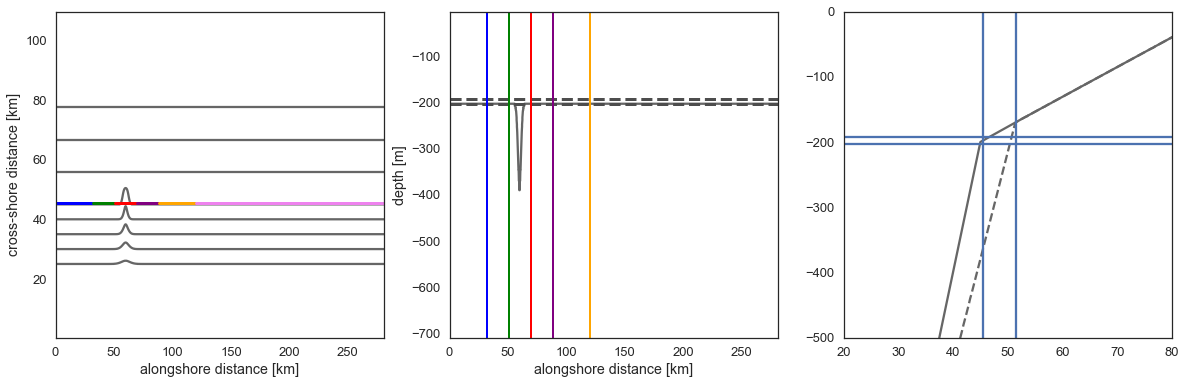

In [3]:
grid_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 3, figsize=(20,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS_y_ind,CS1_x_slice]/1000,grid.YC[CS_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS_y_ind,CS2_x_slice]/1000,grid.YC[CS_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS_y_ind,CS3_x_slice]/1000,grid.YC[CS_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS_y_ind,CS4_x_slice]/1000,grid.YC[CS_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS_y_ind,CS5_x_slice]/1000,grid.YC[CS_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)
ax[0].plot(grid.XC[CS_y_ind,CS6_x_slice]/1000,grid.YC[CS_y_ind,CS6_x_slice]/1000, '-', color='violet', linewidth=3)


ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[CS_y_ind,:]/1000,grid.RC[:80],grid.HFacC[:80,CS_y_ind,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[615]/1000],[grid.RC[BBL_ind],grid.RC[BBL_ind]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[615]/1000],[grid.RC[SB_ind],grid.RC[SB_ind]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)
ax[1].axvline(x=grid.X[360]/1000,color='orange', linewidth=2)

ax[2].plot(grid.Y/1000,-grid.Depth[:,300],color='0.4')
ax[2].plot(grid.Y/1000,-grid.Depth[:,180],'--',color='0.4')
ax[2].axhline(grid.Z[SB_ind])
ax[2].axhline(grid.Z[BBL_ind])
ax[2].axvline(grid.Y[CS_y_ind]/1000)
ax[2].axvline(grid.Y[HD_y_ind]/1000)
ax[2].set_xlim(20,80)
ax[2].set_ylim(-500,0)
ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [5]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, zspacing,hfac, dim_name,zini=0,zfin=40):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    zspacing: xarray, vertical width of vertical levels between faces (drF).
    hfac: fraction of open cell at southern cell face (HFacS variable)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))
    hfacS = hfac.isel(Yp1=y_slice,X=x_slice)

    waterCS_flux = (((dx_CS*vel_CS*hfacS).sum(dim=dim_name))*zspacing).isel(Z=slice(zini,zfin)).sum(dim='Z')

    return waterCS_flux


In [6]:
#set up paths and files
grid_Can_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'
grid_NoC_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'


## CANYON RUN

In [7]:
# Save water transport canyon runs
grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)

filename='/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/stateGlob.nc'
state = xr.open_dataset(filename)

waterCS1_flux = calc_wat_transport_CS(state.V, CS1_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF, grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS2_flux = calc_wat_transport_CS(state.V, CS2_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS3_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS3b_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                       zini=SB_ind,zfin=104)
waterCS4_flux = calc_wat_transport_CS(state.V, CS4_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS5_flux = calc_wat_transport_CS(state.V, CS5_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS6_flux = calc_wat_transport_CS(state.V, CS6_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)

vel_vert = state.W.isel(Zl=SB_ind,Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind))
area = (grid.rA.isel(Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind)))

waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
waterVert_flux.name = 'Vert_water_trans_sb'
waterVert_flux.attrs['units'] = 'm3/s'

waterCS1_flux.name = 'CS1_water_trans'
waterCS1_flux.attrs['units'] = 'm3/s'
waterCS2_flux.name = 'CS2_water_trans'
waterCS2_flux.attrs['units'] = 'm3/s'
waterCS3_flux.name = 'CS3_water_trans'
waterCS3_flux.attrs['units'] = 'm3/s'
waterCS3b_flux.name = 'CS3b_water_trans'
waterCS3b_flux.attrs['units'] = 'm3/s'
waterCS4_flux.name = 'CS4_water_trans'
waterCS4_flux.attrs['units'] = 'm3/s'
waterCS5_flux.name = 'CS5_water_trans'
waterCS5_flux.attrs['units'] = 'm3/s'
waterCS6_flux.name = 'CS6_water_trans'
waterCS6_flux.attrs['units'] = 'm3/s'

objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
             waterCS5_flux,waterCS6_flux,waterVert_flux]

DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')

DS_CS_path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/water_CS_transports.nc')
DS_CS.to_netcdf(path=DS_CS_path, mode='w',engine='scipy')

print(DS_CS_path)


/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/water_CS_transports.nc


In [17]:
# Save water transport canyon runs - BBL Band
grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)

filename='/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc'
state = xr.open_dataset(filename)

waterCS1_flux = calc_wat_transport_CS(state.V, CS1_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF, grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS2_flux = calc_wat_transport_CS(state.V, CS2_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS3_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1) # I don't need this one. Calculate just in case
waterCS4_flux = calc_wat_transport_CS(state.V, CS4_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS5_flux = calc_wat_transport_CS(state.V, CS5_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS6_flux = calc_wat_transport_CS(state.V, CS6_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)

vel_vert = state.W.isel(Zl=SB_ind,Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind))
area = (grid.rA.isel(Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind)))

waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
waterVert_flux.name = 'Vert_water_trans_sb'
waterVert_flux.attrs['units'] = 'm3/s'
waterCS1_flux.name = 'CS1_water_trans'
waterCS1_flux.attrs['units'] = 'm3/s'
waterCS2_flux.name = 'CS2_water_trans'
waterCS2_flux.attrs['units'] = 'm3/s'
waterCS3_flux.name = 'CS3_water_trans'
waterCS3_flux.attrs['units'] = 'm3/s'
waterCS4_flux.name = 'CS4_water_trans'
waterCS4_flux.attrs['units'] = 'm3/s'
waterCS5_flux.name = 'CS5_water_trans'
waterCS5_flux.attrs['units'] = 'm3/s'
waterCS6_flux.name = 'CS6_water_trans'
waterCS6_flux.attrs['units'] = 'm3/s'

objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS4_flux,
             waterCS5_flux,waterCS6_flux,waterVert_flux]

DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')

DS_CS_path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/water_CS_BBL_transports.nc')
DS_CS.to_netcdf(path=DS_CS_path, mode='w',engine='scipy')

print(DS_CS_path)


/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/water_CS_BBL_transports.nc


## NO CANYON RUN

In [9]:
# Save water transport canyon runs
grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)

filename='/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/stateGlob.nc'
state = xr.open_dataset(filename)

waterCS1_flux = calc_wat_transport_CS(state.V, CS1_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF, gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS2_flux = calc_wat_transport_CS(state.V, CS2_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS3_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS3b_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                       zini=SB_ind,zfin=104)
waterCS4_flux = calc_wat_transport_CS(state.V, CS4_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS5_flux = calc_wat_transport_CS(state.V, CS5_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)
waterCS6_flux = calc_wat_transport_CS(state.V, CS6_x_slice, CS_y_ind,
                                      gridNoC.dxG, gridNoC.drF , gridNoC.HFacS, 'X',
                                      zini=0, zfin=SB_ind+1)

vel_vert = (state.W.isel(Zl=SB_ind,Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind)))
area = (gridNoC.rA.isel(Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind)))

waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
waterVert_flux.name = 'Vert_water_trans_sb'
waterVert_flux.attrs['units'] = 'm3/s'

waterCS1_flux.name = 'CS1_water_trans'
waterCS1_flux.attrs['units'] = 'm3/s'
waterCS2_flux.name = 'CS2_water_trans'
waterCS2_flux.attrs['units'] = 'm3/s'
waterCS3_flux.name = 'CS3_water_trans'
waterCS3_flux.attrs['units'] = 'm3/s'
waterCS3b_flux.name = 'CS3b_water_trans'
waterCS3_flux.attrs['units'] = 'm3/s'
waterCS4_flux.name = 'CS4_water_trans'
waterCS4_flux.attrs['units'] = 'm3/s'
waterCS5_flux.name = 'CS5_water_trans'
waterCS5_flux.attrs['units'] = 'm3/s'
waterCS6_flux.name = 'CS6_water_trans'
waterCS6_flux.attrs['units'] = 'm3/s'

objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
             waterCS5_flux,waterCS6_flux,waterVert_flux]

DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')

DS_CS_path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/water_CS_transports.nc')
DS_CS.to_netcdf(path=DS_CS_path, mode='w',engine='scipy')

print(DS_CS_path)


/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/water_CS_transports.nc


In [18]:
# Save water transport no canyon runs - BBL Band
grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)

filename='/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/stateGlob.nc'
state = xr.open_dataset(filename)

waterCS1_flux = calc_wat_transport_CS(state.V, CS1_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF, grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS2_flux = calc_wat_transport_CS(state.V, CS2_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS3_flux = calc_wat_transport_CS(state.V, CS3_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1) # I don't need this one. Calculate just in case
waterCS4_flux = calc_wat_transport_CS(state.V, CS4_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS5_flux = calc_wat_transport_CS(state.V, CS5_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)
waterCS6_flux = calc_wat_transport_CS(state.V, CS6_x_slice, CS_y_ind,
                                      grid.dxG, grid.drF , grid.HFacS, 'X',
                                      zini=BBL_ind, zfin=SB_ind+1)

vel_vert = state.W.isel(Zl=SB_ind,Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind))
area = (grid.rA.isel(Y=slice(CS_y_ind,HD_y_ind), X=slice(UP_x_ind,DN_x_ind)))
waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X') # I don't need this one. Calculate just in case

waterVert_flux.name = 'Vert_water_trans_sb'
waterVert_flux.attrs['units'] = 'm3/s'
waterCS1_flux.name = 'CS1_water_trans'
waterCS1_flux.attrs['units'] = 'm3/s'
waterCS2_flux.name = 'CS2_water_trans'
waterCS2_flux.attrs['units'] = 'm3/s'
waterCS3_flux.name = 'CS3_water_trans'
waterCS3_flux.attrs['units'] = 'm3/s'
waterCS4_flux.name = 'CS4_water_trans'
waterCS4_flux.attrs['units'] = 'm3/s'
waterCS5_flux.name = 'CS5_water_trans'
waterCS5_flux.attrs['units'] = 'm3/s'
waterCS6_flux.name = 'CS6_water_trans'
waterCS6_flux.attrs['units'] = 'm3/s'

objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS4_flux,
             waterCS5_flux,waterCS6_flux,waterVert_flux]

DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')

DS_CS_path = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/water_CS_BBL_transports.nc')
DS_CS.to_netcdf(path=DS_CS_path, mode='w',engine='scipy')

print(DS_CS_path)


/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/water_CS_BBL_transports.nc
